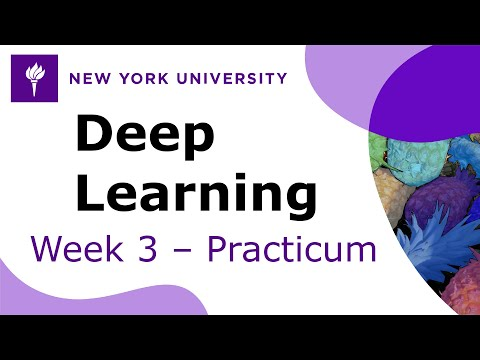

In [1]:
from IPython.display import YouTubeVideo
from datetime import timedelta

YouTubeVideo('kwPWpVverkw', width=800, height=500, start=int(timedelta(minutes=43, seconds=33).total_seconds()))

# Outline

* Today we will show how to train a ConvNet using PyTorch
* We will also illustrate how the ConvNet makes use of specific assumptions

# To perform well, we need to incorporate some prior knowledge about the problem

* Assumptions helps us when they are true
* They hurt us when they are not
* We want to make just the right amount of assumptions, not more than that

## In Deep Learning

* Many layers: compositionality
* Convolutions: locality + stationarity of images
* Pooling: Invariance of object class to translations

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import os

from IPython import display

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the Dataset (MNIST)

We can use some PyTorch DataLoader utilities for this. This will download, shuffle, normalize data and arrange it in batches.

In [ ]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

data_path = os.path.join(os.path.abspath('.'), 'data')

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_path, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_path, train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

In [ ]:
# show some images
plt.figure(figsize=(10,8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze())
    plt.axis('off');

# Feed Forward Neural Network
First we construct a MLP Network using the [nn.sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). The network consist of:<br>
<br>
>Linear input Layer<br>
ReLu activation<br>
Linear hidden layer<br>
Relu activation<br>
Linear output layer<br>
Logsoftmax function<br>
<br>
consider the following links for a description of different activation functions:<br>
[nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)<br>
[nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)<br>
[nn.LogSoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html)<br>
<br>

Why can we interpret the output of the network as the vector of probability values for each class?

In [ ]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
    
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)    
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

# Create the model class for the CNN
Construct your Convolutional Neural Network this time without using the nn.sequential class. The network should consist of:<br>
<br>
>2D Convolutional Layer (1 = in_channel, n_feature = out_channels)<br>
2D Convolutional Layer<br>
Linear hidden layer<br>
Linear output layer<br>
Logsoftmax function<br>
<br>
use relu activation and max pooling after every convolutional layer and relu activation after the first linear layer. Use a kernel size of 5 for the convolutions and kernel size 2 for the pooling layer

use the following links for class description:<br>
[nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
[F.relu](https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html#torch.nn.functional.relu)
[F.max_pool2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.max_pool2d.html#torch.nn.functional.max_pool2d)
[nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
[F.log_softmax](https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html#torch.nn.functional.log_softmax)
<br>
The output of the network should be interpreted as the vector of probability values for each class

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
# Create Fully Connected MLP
n_hidden = 8 # number of hidden units
model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)

In [ ]:
# Create Convolutional Neural Network
n_features = 6 # number of feature maps
model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)

# Define train and test functions
Construct construct training and testing function, use the [ F.nll_loss](https://pytorch.org/docs/stable/generated/torch.nn.functional.nll_loss.html#torch.nn.functional.nll_loss)
<br>
The predicted class of the network is the argmax of the outputvector

In [ ]:
def train(epoch, model, optimizer, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        # plot the accuracy
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            display.clear_output(wait=True)
            
def test(model, perm=torch.arange(0, 784).long()):
    
    acc_list = []
    
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    acc_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    
    return np.array(acc_list).mean()

# Train a small fully-connected network

In [ ]:
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

In [ ]:
accuracy_list = []

In [ ]:
loc_acc = []

for epoch in range(0, 1):
    train(epoch, model_fnn,optimizer)
    loc_acc.append(test(model_fnn))
    
accuracy_list.append(np.array(loc_acc).mean())

# Train a ConvNet with the same number of parameters

In [ ]:
# Training settings 
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

In [ ]:
loc_acc = []

for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer)
    loc_acc.append(test(model_cnn))
    
accuracy_list.append(np.array(loc_acc).mean())

# The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images

* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

# What happens if the assumptions are no longer true?


In [ ]:
torch.manual_seed(865321)

perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze())
    plt.axis('off')

# Fully-Connected with Permuted Pixels

In [ ]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

In [ ]:
loc_acc = []

for epoch in range(0, 1):
    train(epoch, model_fnn, optimizer, perm)
    loc_acc.append(test(model_fnn, perm))
    
accuracy_list.append(np.array(loc_acc).mean())

# ConvNet with permuted pixels

In [ ]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

In [ ]:
loc_acc = []

for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer, perm)
    loc_acc.append(test(model_cnn, perm))
    
accuracy_list.append(np.array(loc_acc).mean())

# The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

* ConvNet makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

In [ ]:
plt.bar(('NN', 'CNN',
         'NN scr', 'CNN scr'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    plt.title('Performance comparison')

In [ ]:
accuracy_list